# "[Neural Network] Introduction of Autoencoder"
> Introduction of Auto Encoder

- toc: false
- badges: false
- comments: false
- categories: [neural-network, auto-encoder, representation-learning]
- hide_{github,colab,binder,deepnote}_badge: true

# 1. Overview

An autoencoder is a type of artificial neural network used to learn efficient data encoding and decoding in an unsupervised(more exactly, self-supervised) manner. The aim of autoencoder is to learn a __representation(encoding)__ for a set of data, typically for dimensionality reduction.<br><br>

Several variants exists:
- Sparse autoencoders
- Denoising autoencoders
- Variational autoencoders
- etc

Applications:
- Dimensionality reduction
- Data compression
- __Representation learning__
- Face recognition
- etc

# 2. Autoencoder
## 2.1. Architecture
An autoencoder learns to copy its input at its output

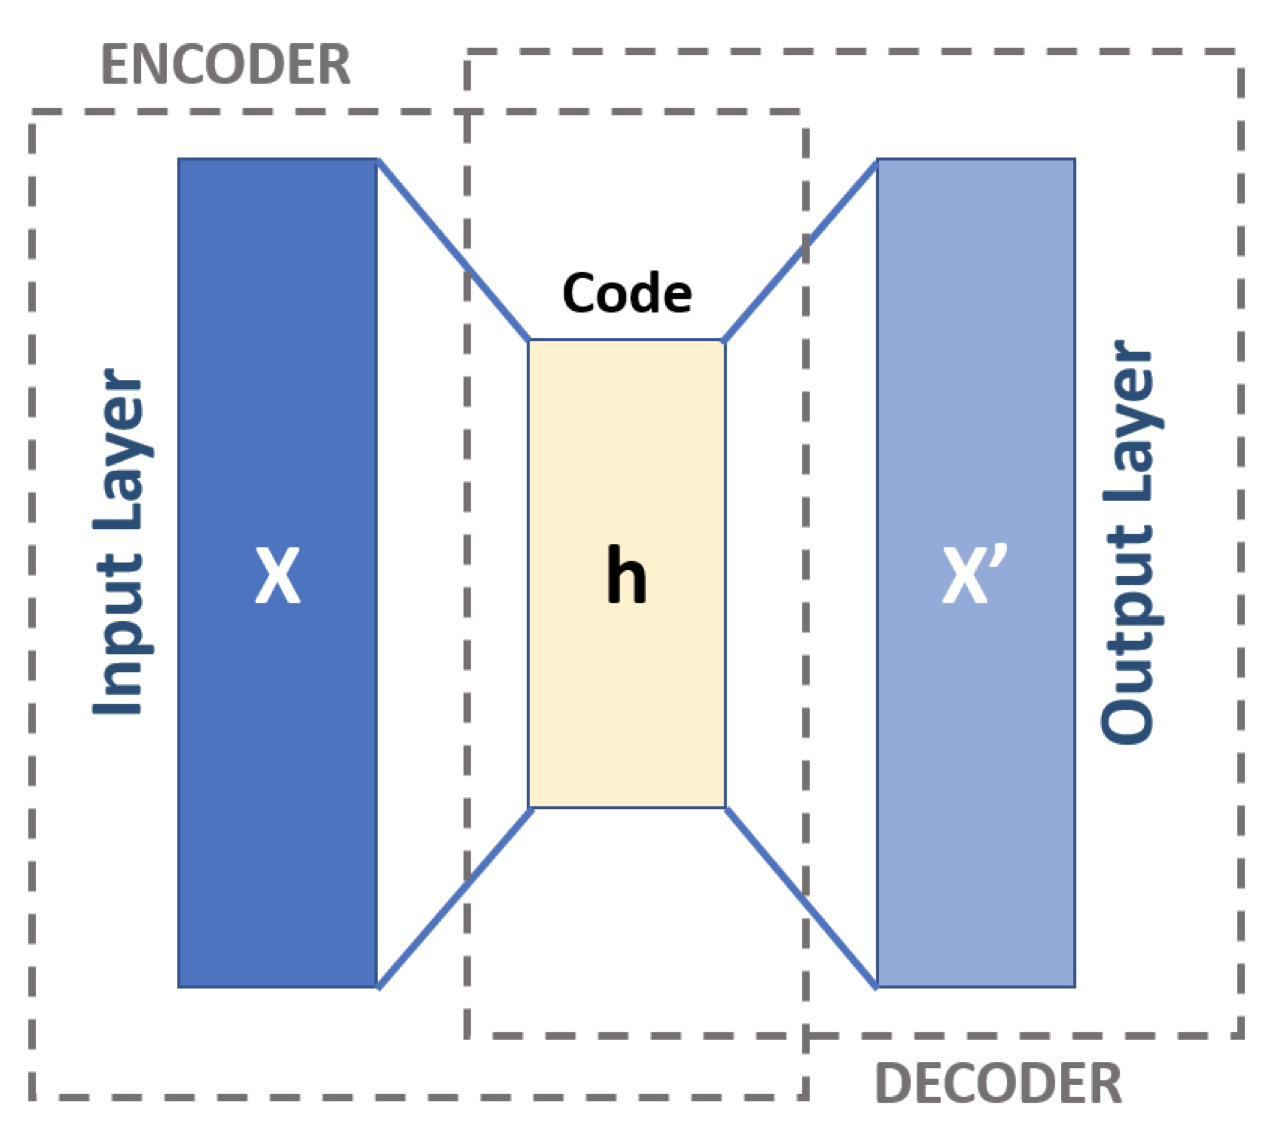

In [3]:
Image("fig1.png", width=500)

A simple form of autoencoder is composed of an input layer, a hidden layer, and an output layer. 

$$
\phi : \mathbf{x} \in \mathbb{R}^d \rightarrow \mathbf{h} \in \mathbb{R}^p
$$

$$
\mathbf{h} = \sigma(W\mathbf{x} + \mathbf{b}) \in \mathbb{R}^p
$$
where $\mathbf{h}$ is called code, hidden variable, or __latent variable__.

$$
\psi : \mathbf{h} \in \mathbb{R}^p \rightarrow \mathbf{x}^\prime \in \mathbb{R}^d
$$

$$
\mathbf{x}^\prime = \sigma^\prime (W^\prime \mathbf{h} + \mathbf{b}^\prime)
$$

It is often constrained that $W = (W^\prime)^T$. Encoder maps the input into the code, and decoder maps the code to a __reconstruction__ of the original input. 

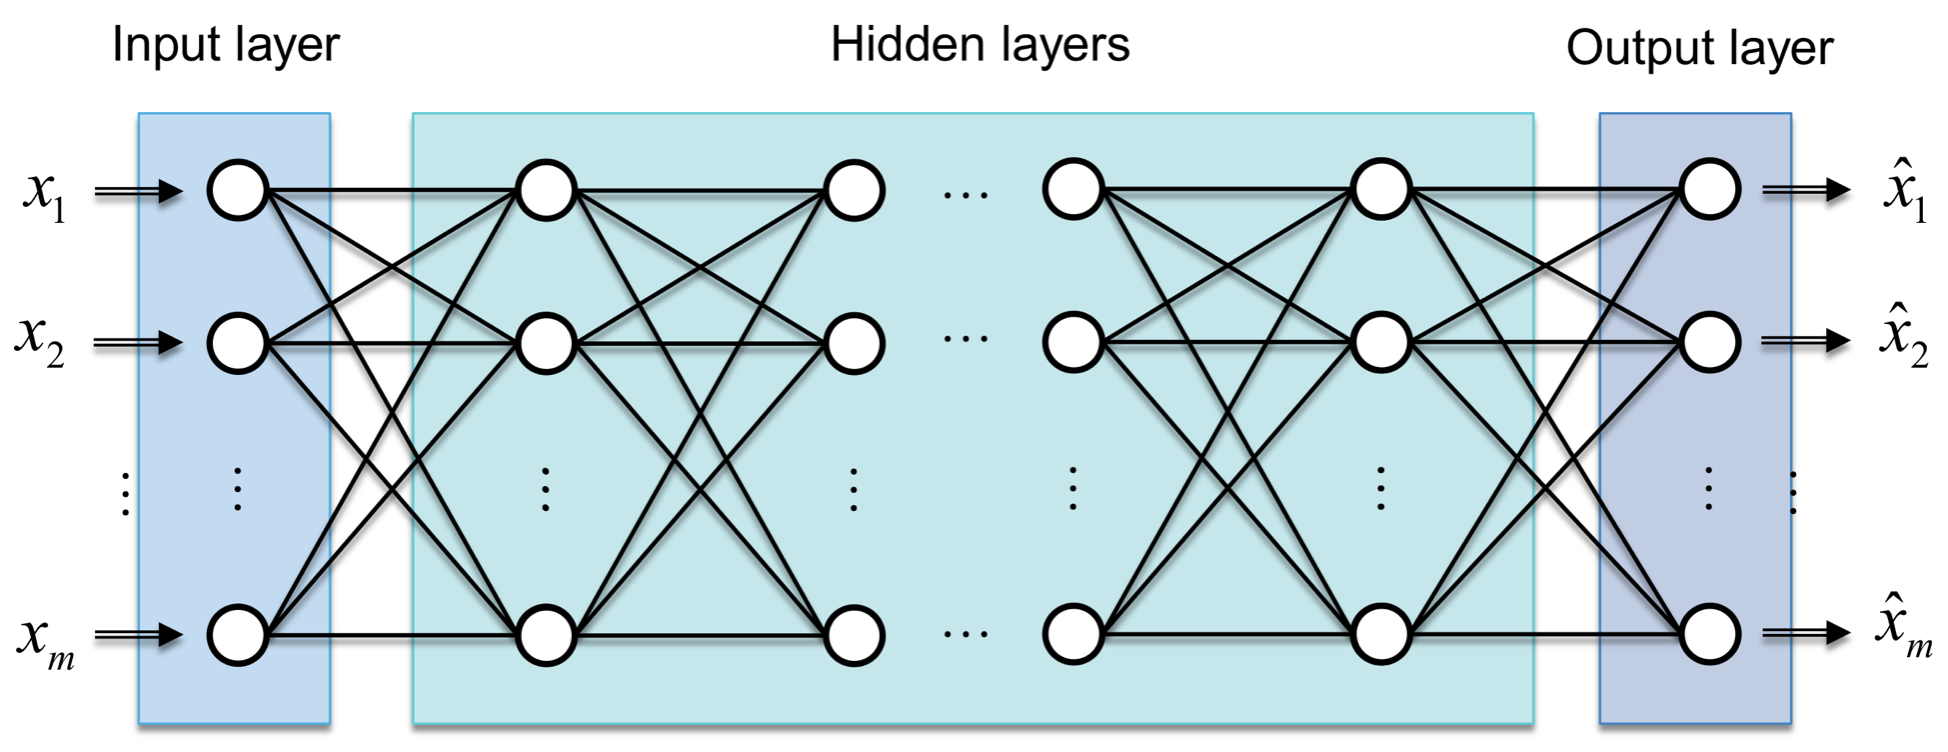

In [5]:
Image("fig2.png", width=600)

Autoencoder can have a deep architecture. In this time, input-output relationship is

$$
\hat{\mathbf{x}} = \varphi_o( W_o \varphi_L ( W_L \varphi_{L - 1} ( \cdots (W_1\mathbf{x} + \mathbf{b}_1) \cdots) + \mathbf{b}_L) + \mathbf{b}_o)
$$

## 2.2. Training

Autoencoders are trained to minimize reconstruction errors such as mean squared errors.
Here is some tip to training autoencoders.

- Continuous input : MSE

$$
\mathcal{L}(\mathbf{x}, \mathbf{x}^\prime) = \mathbb{E}\left[ ||\mathbf{x} - \mathbf{x}^\prime||^2 \right]
$$
where the expectation is taken over training samples.

- Discrete input : cross-entropy
$$
\mathcal{L}(\mathbf{x}, \mathbf{x}^\prime) = - \frac{1}{N} \sum_{i = 1}^N (x_i \log_\hat{x_i} + (1 - x_i) \log (1 - \hat{x_i}) ) 
$$
where softmax activation function is uesd at output nodes.<br><br>

The training of autoencoder can be performed through the backprop.

## 2.3. Properties

In general, autoencoders perform compression by setting. Therefore, there must be information loss.<br> 

If linear activations are used, or only a single sigmoid hidden layer, then the optimal solution to an autoencoder is strongly related to principal component analysis(PCA). If $p \,\ \text{(number of hidden nodes)} < d \,\ \text{(number of input nodes)}$, the weights of autoencoder span the same vector subspace as the one spanned by the first $p$ principal components, and the output of the autoencoder is an orthogonal projection onto this subspace. The autoencoder weights are not equal to the principal components, and are generally not orthogonal, yet the principal components may be recovered from them using the singular value decomposition. 

> Autoencoder is more powerful than PCA due to its nonlinearity.

# 3. Sparse Autoencoder
$$
p \ge d
$$

Sparse autoencoder may include more hidden units thatn inputs, but only a small number of the hidden units are allowed to be active at once.

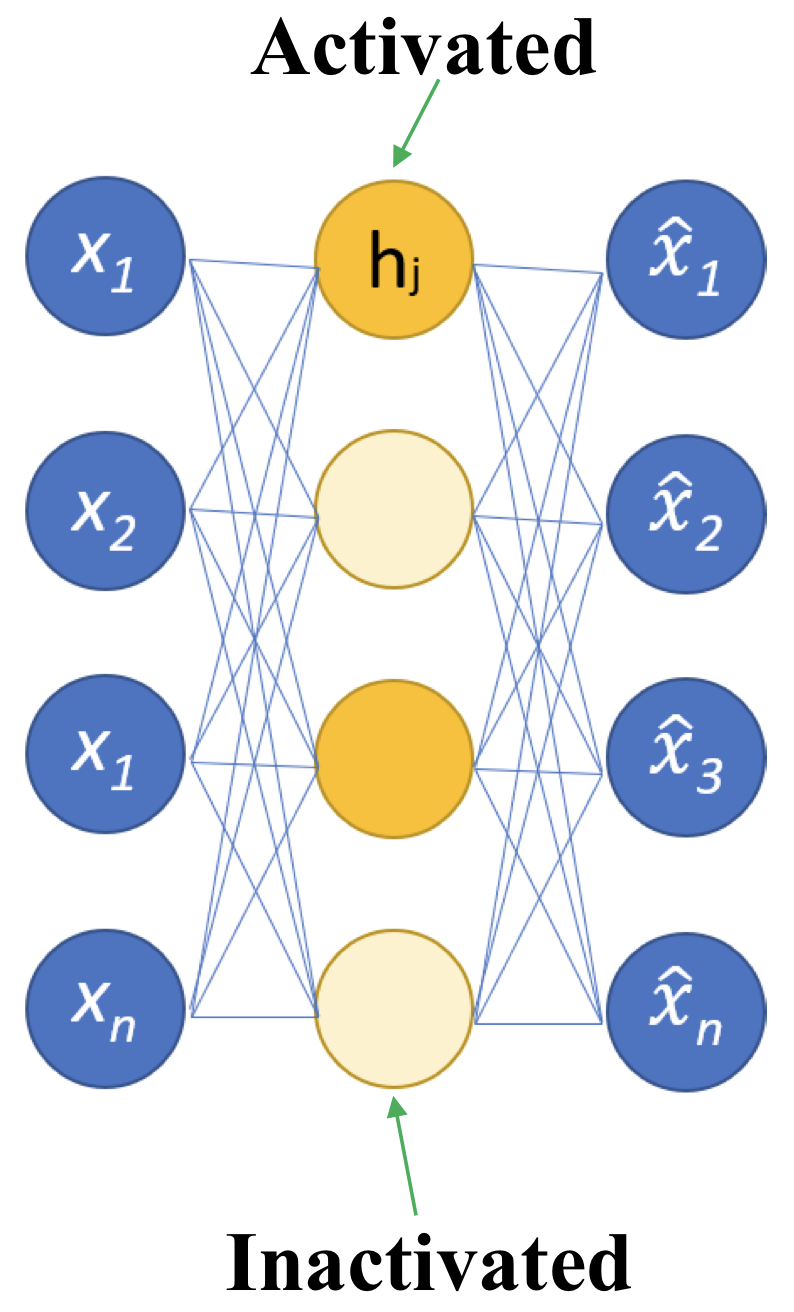

In [7]:
Image("fig3.png", width=200)

Only above orange hidden nodes can activate at once. <br>

It learns representations in a way that encourages sparsity, imporved performance is obtained on __classification tasks__. Specifically, a sparse autoencoder is an autoencoder whose training criterion involves a __sparsity penalty__ $\Omega(\mathbf{h})$ on the code. A popular sparsity constraint is the KL divergence with additionally considering L1 or L2 regularization constraint

$$
\frac{1}{N} \sum_{i = 1}^N \mathcal{L}(x_i, \hat{x_i}) + \lambda(||W|| + ||W||^2) + \beta \sum_{j = 1}^m D_{KL}(\rho || \hat{\rho_j})
$$

where $\hat{\rho_j} = \frac{1}{N} \sum_{i = 1}^N h_j(x_i)$ is an average activation of the hidden unit $j$.

# 4. Denoising Autoencoder

DAEs take a partially corrupted input and are trained to recover the original undistorted input. In pactice, the objective of denoising autoencoders is that of clearning the corrupted input, or denoising. The input is corrupted by through stochastic mapping

$$
\overset{\sim}{\mathbf{x}} \sim q_D(\overset{\sim}{\mathbf{x}} | \mathbf{x})
$$


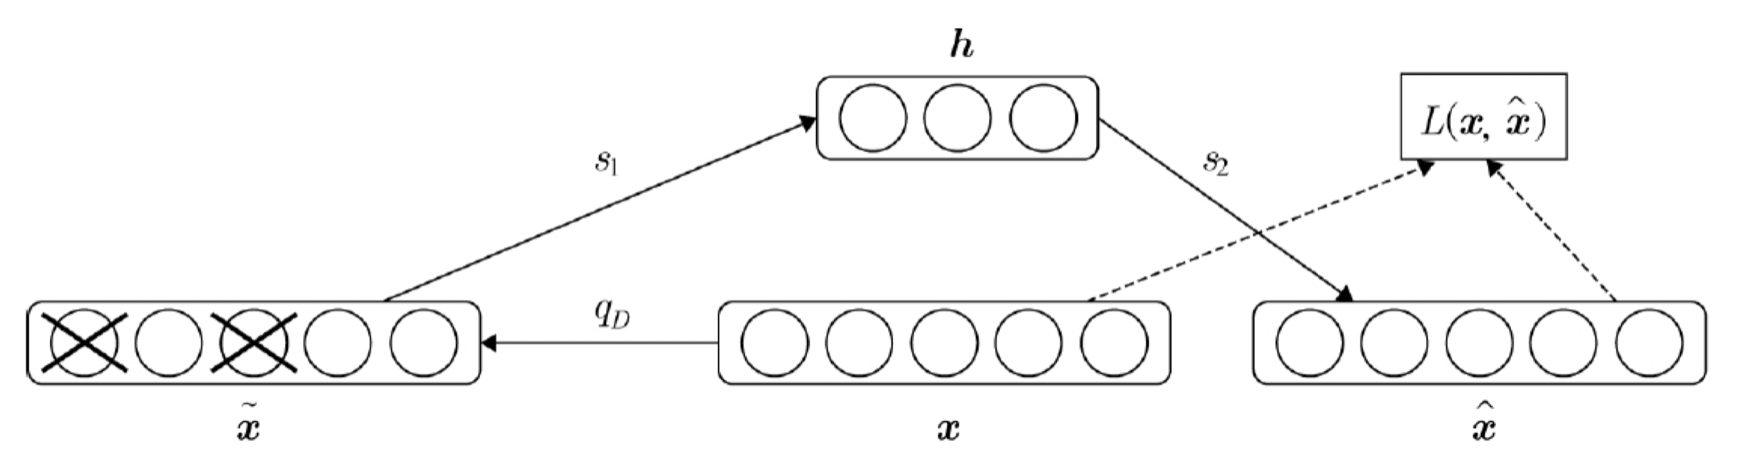

In [8]:
Image("fig4.png", width=600)

There are some kinds of corruption processes.

- Gaussian noise :
$$
\overset{\sim}{\mathbf{x}} | \mathbf{x} \sim \mathcal{N}(\mathbf{x}, \mathbf{\sigma}^2I)
$$

- Masking noise : A fraction of the input chosen at random for each example is forced to 0.

- Salt-and-pepper noise : A fraction of the input chosen at random for each example is set to its minimum of maximum value with uniform probability.

Notice that the corrption of the input is performed only during the training phase of the DAE. Once the model has learnt the optimal parameters, in order to extract the representations from the original data, __no corruption is added__.

# 5. Simple Implementation of Basic Autoencoder
In this time, we construct autoencoder model, basically. Our purpose is to learn the representation of the MNIST dataset and compress it into a one-dimensional latent variable. After that, we will try to generate various number handwriting by adjusting the one-dimensional latent variable.

We have to import following modules.

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

Get MNIST dataset and create dataset and module.

In [2]:
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=64,
    shuffle=True,
    num_workers=1
)

Create model. For good performance, we have to use

- Good generalization performance
- Xavier initialize
- Batch normalization
- Proper learning rate
- etc

In pytorch, ```nn.Linear``` layers are initialized xavier initializing, automatically. 

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.BatchNorm1d(1),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.BatchNorm1d(28*28),
            nn.Sigmoid(),
        )
        
    
    def forward(self, x):
        latent = self.encoder(x)
        decoded = self.decoder(latent)
        return latent, decoded

In [4]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", dev)

Device : cuda


In [7]:
model = AE().to(dev)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
def train(model, train_loader, epoch):
    model.train()
    for i in range(epoch):
        sum_loss = 0.0
        for data, label in train_loader:
            data = data.view(-1, 28*28).to(dev)
            label = label.to(dev)
            predict = model(data)[1]
            loss = criterion(predict, data)
            sum_loss += loss

            optim.zero_grad()
            loss.backward()
            optim.step()
        print("EPOCH {}: loss - {}".format(i + 1, sum_loss))

train(model, train_loader, 100)

EPOCH 1: loss - 144.8663787841797<br>
EPOCH 2: loss - 90.95703887939453<br>
EPOCH 3: loss - 74.48108673095703<br>
EPOCH 4: loss - 67.24845123291016<br>
EPOCH 5: loss - 63.10108947753906<br>
EPOCH 6: loss - 56.50653839111328<br>
EPOCH 7: loss - 50.313140869140625<br>
EPOCH 8: loss - 48.538490295410156<br>
EPOCH 9: loss - 47.55280303955078<br>
EPOCH 10: loss - 46.87140655517578<br>
EPOCH 11: loss - 46.44161605834961<br>
EPOCH 12: loss - 45.992095947265625<br>
EPOCH 13: loss - 45.9116325378418<br>
EPOCH 14: loss - 45.62765884399414<br>
EPOCH 15: loss - 45.36041259765625<br>
EPOCH 16: loss - 45.25257873535156<br>
EPOCH 17: loss - 44.98619079589844<br>
EPOCH 18: loss - 44.94349670410156<br>
EPOCH 19: loss - 44.7140007019043<br>
EPOCH 20: loss - 44.542564392089844<br>
EPOCH 21: loss - 44.31476974487305<br>
EPOCH 22: loss - 44.24300003051758<br>
EPOCH 23: loss - 44.26637268066406<br>
EPOCH 24: loss - 44.159706115722656<br>
EPOCH 25: loss - 44.04599380493164<br>
EPOCH 26: loss - 44.11685562133789<br>
EPOCH 27: loss - 43.9760627746582<br>
EPOCH 28: loss - 43.82699966430664<br>
EPOCH 29: loss - 43.77445602416992<br>
EPOCH 30: loss - 43.685997009277344<br>
EPOCH 31: loss - 43.655799865722656<br>
EPOCH 32: loss - 43.6832275390625<br>
EPOCH 33: loss - 43.557071685791016<br>
EPOCH 34: loss - 43.550148010253906<br>
EPOCH 35: loss - 43.56989669799805<br>
EPOCH 36: loss - 43.48973083496094<br>
EPOCH 37: loss - 43.35897445678711

We stop the learning because the loss value shows no significant change. Of course, there are other good methods such as lr scheduler, but since it is a simple experiment, learn only this.

And then, create various non-handwriting data.

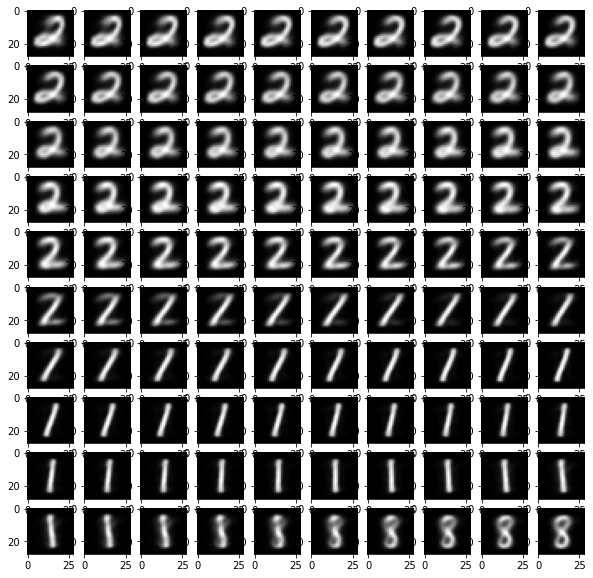

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
with torch.no_grad():
    model.eval()
    for idx, i in enumerate(np.arange(-1, 1, 0.01)):
        data = model.decoder(torch.Tensor([[i]]).to(dev))
        data = data.view(28, 28)
        if idx == 100: 
            break
        plt.subplot(10, 10, idx + 1)
        plt.imshow(data.cpu().numpy(), cmap='gray')
plt.show()

# Comment
The reason why autoencoders have great significance is because of __the limitations of data labeling__. It is one of the big issues to have to label each data used when training a neural network. However, the autoencoder is very attractive from the point of view of being able to learn and process representations on data from the point of view of a model (even labeling is irrelevant). These self-supervised learning, semi-supervised learning, and unsupervised learning are fields that are being continuously studied. Since it can be used for the overall model, these contents are not limited to a specific field, but should be looked at in all fields using neural networks. Representatively GAN, self-supervised learning, SimCLR, and autoencoder.